In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import os
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error

## 神经网络预测结果

In [39]:
log_file = 'log/20250523_190216'

with open("statistics.pkl", "rb") as f:
    sta = pickle.load(f)

z_data = pd.read_csv('data/zscore_data.csv')
z_data['date'] = pd.to_datetime(z_data['date'])
z_data['OT'] = z_data['OT']*sta['std']['OT']+sta['mean']['OT']

train_split_date = pd.to_datetime("2017-07-01")
result_df = z_data[z_data['date'] >= train_split_date][['date', 'OT']]

In [40]:
def result(model_name):
    file_pattern = os.path.join(log_file, 'pred/best_'+model_name+"_seed42_pred_window*.npz")
    file_list = glob.glob(file_pattern)
    result = np.zeros(len(result_df))
    p = 0

    for file_path in file_list:
        frac_pred = np.load(file_path)['pred']
        result[p: p+len(frac_pred)] = frac_pred
        p += len(frac_pred)


    result_df[model_name] = result*sta['std']['OT']+sta['mean']['OT']

<Axes: xlabel='date'>

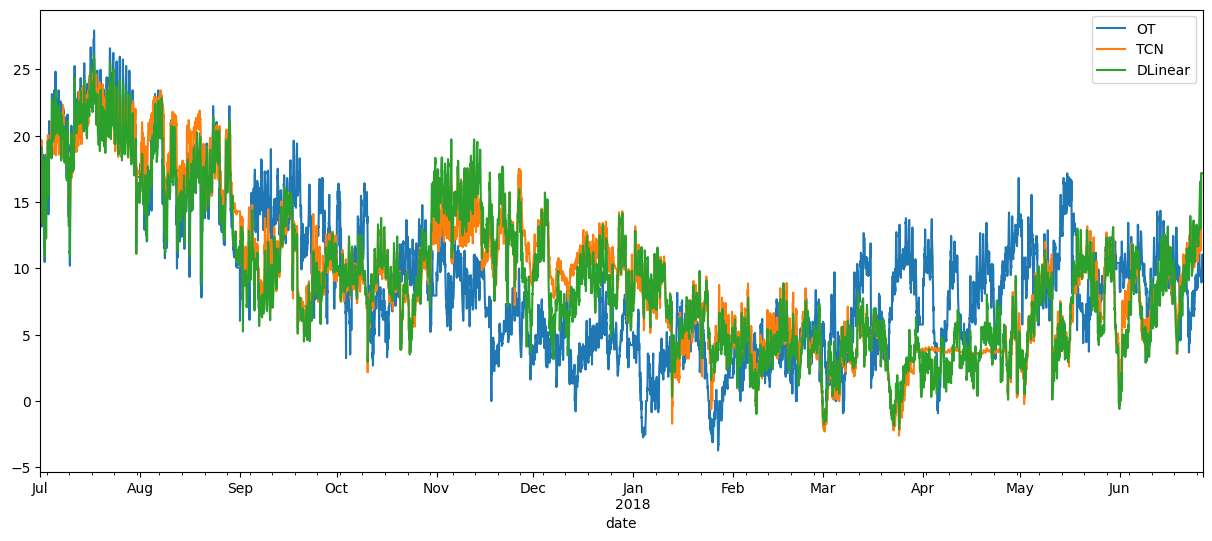

In [41]:
result('DLinear')
result('TCN')
result_df['nn_Combined'] = (result_df['DLinear'] + result_df['TCN']) / 2

result_df[['date', 'OT', 'TCN', 'DLinear']].set_index('date').plot(figsize=(15, 6))

In [42]:
dl_total_loss = mean_squared_error(result_df['DLinear'], result_df['OT']), mean_absolute_error(result_df['DLinear'], result_df['OT'])
tcn_total_loss = mean_squared_error(result_df['TCN'], result_df['OT']), mean_absolute_error(result_df['TCN'], result_df['OT'])
combined_total_loss = mean_squared_error(result_df['nn_Combined'], result_df['OT']), mean_absolute_error(result_df['nn_Combined'], result_df['OT'])

loss_dict = {
    'DLinear': dl_total_loss,
    'TCN': tcn_total_loss,
    'nn_Combined': combined_total_loss
}

pd.DataFrame(loss_dict, index=['MSE_loss', 'MAE_loss'])

,DLinear,TCN,nn_Combined
MSE_loss,21.393211,21.863234,21.080747
MAE_loss,3.592431,3.722082,3.607959


In [ ]:
rolling_mse_df = {}
rolling_mae_df = {}

def rolling_result(model_name):
    p = 0
    result_l_mse = []
    result_l_mae = []
    for i in range(12):
        temp_df = result_df.copy()

        file_path = os.path.join(log_file, f'pred/best_{model_name}_seed42_pred_window{i}.npz')
        frac_pred = np.load(file_path)['pred']

        true_label = temp_df[p: p+len(frac_pred)]['OT'].values
        p += len(frac_pred)


        frac_pred = frac_pred*sta['std']['OT']+sta['mean']['OT']

        result_l_mse.append(mean_squared_error(frac_pred, true_label))
        result_l_mae.append(mean_absolute_error(frac_pred, true_label))
    rolling_mse_df[model_name] = result_l_mse
    rolling_mae_df[model_name] = result_l_mae


rolling_result('DLinear')
rolling_result('TCN')

#### 神经网络的loss曲线

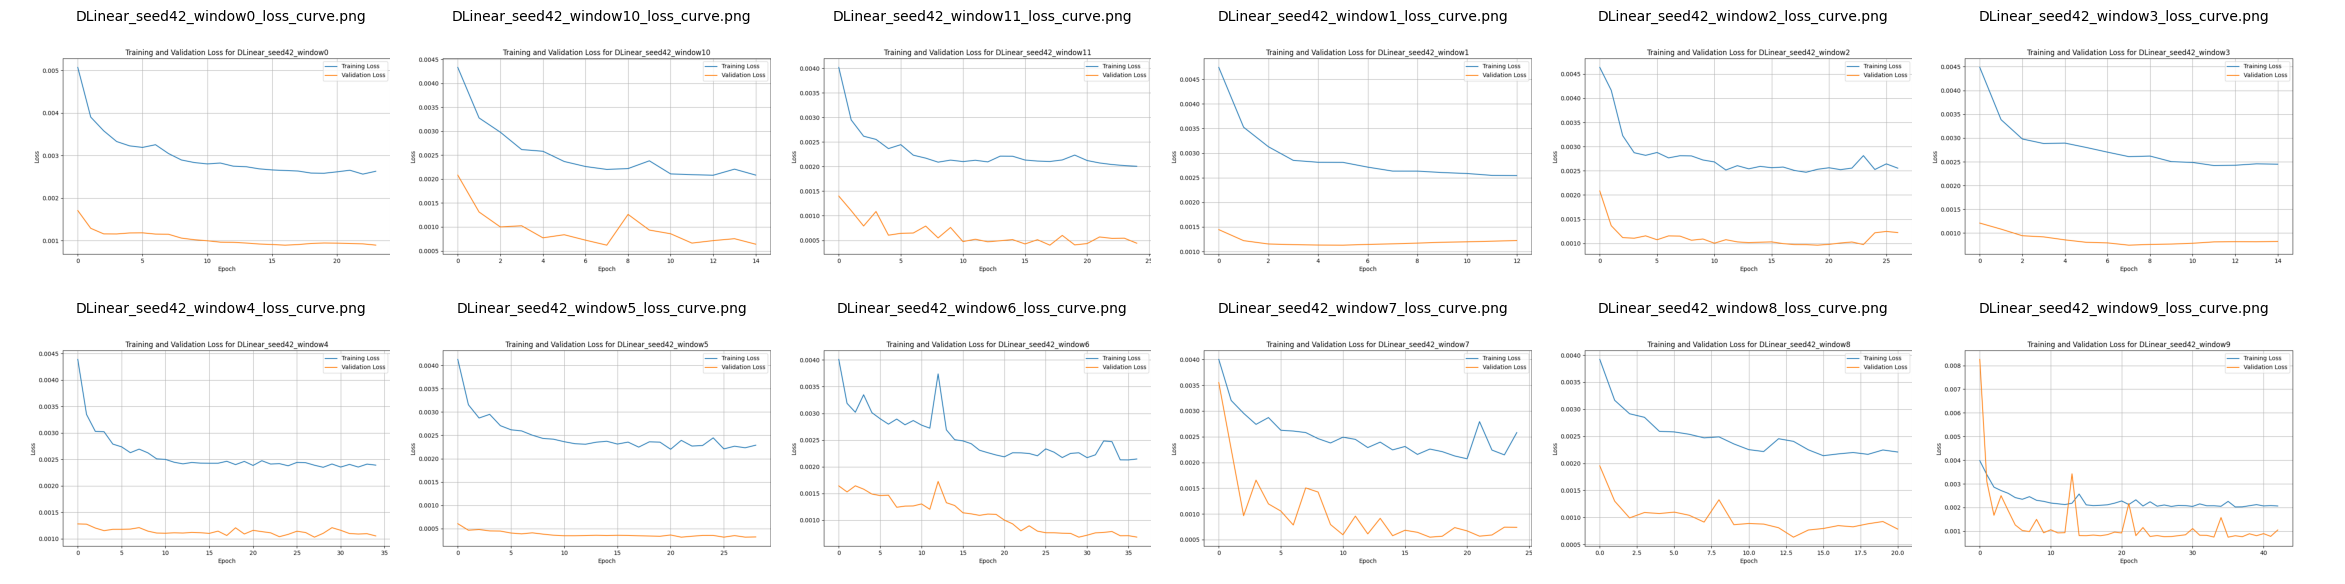

In [44]:
image_directory = os.path.join(log_file, 'curve/')
model_name = 'DLinear'
figsize = (30, 8)
image_files = [f for f in os.listdir(image_directory) 
                if (f.endswith('.png') and (f.startswith(model_name)))]
n_images = len(image_files)
# 创建图形和子图
fig, axes = plt.subplots(2, 6, figsize=figsize)


# 调整子图间距
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)


for i, img_file in enumerate(image_files):
    row, col = i // 6, i % 6
    img_path = os.path.join(image_directory, img_file)
    
    img = mpimg.imread(img_path)
    axes[row][col].imshow(img)
    axes[row][col].axis('off')
    axes[row][col].set_title(img_file, fontsize=10)


plt.show()

## 统计模型预测结果

In [45]:
log_file = 'lgbm_pred'

In [46]:
def result():
    file_pattern = os.path.join(log_file, 'lgbm_pred_window_*.npz')
    file_list = glob.glob(file_pattern)
    result = np.empty(len(result_df))
    p = 0

    for file_path in file_list:
        frac_pred = np.load(file_path)['pred']
        result[p: p+len(frac_pred)] = frac_pred
        p += len(frac_pred)


    result_df['lgbm'] = result*sta['std']['OT']+sta['mean']['OT']

<Axes: xlabel='date'>

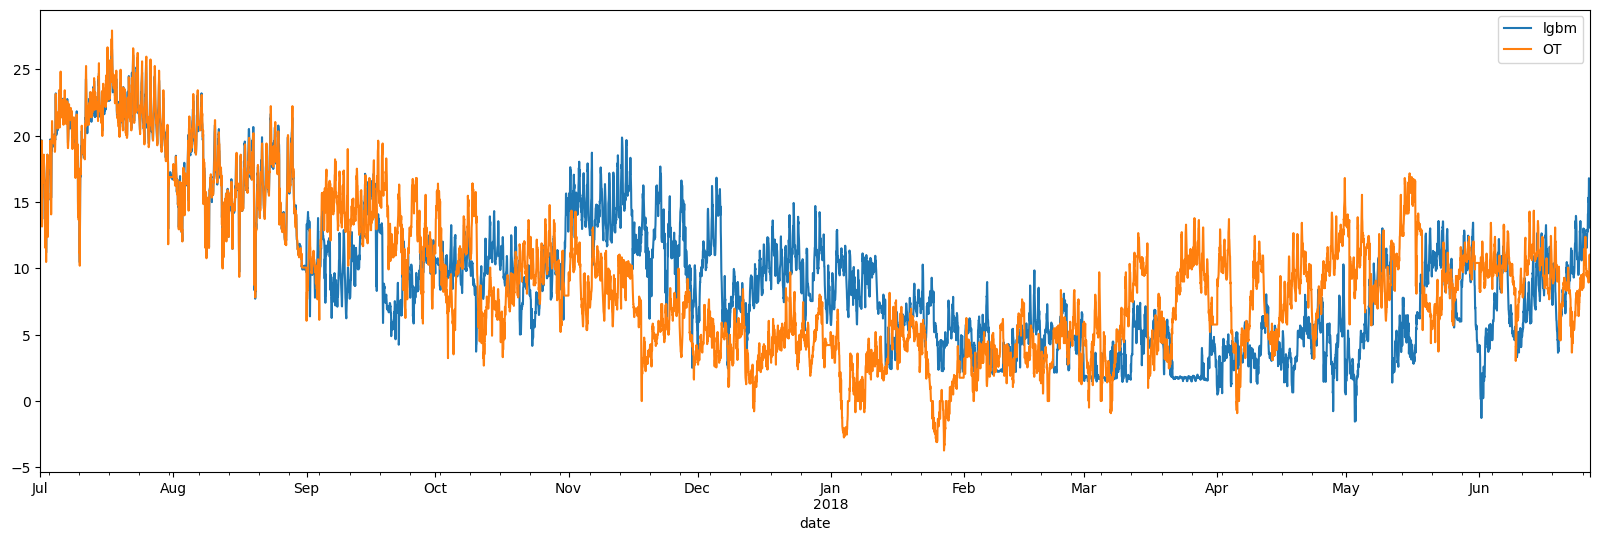

In [48]:
result_lgbm()

result_df[['date', 'lgbm', 'OT']].set_index('date').plot(figsize=(20, 6))

In [ ]:
def rolling_result_lgbm():
    p = 0
    result_l_mse = []
    result_l_mae = []
    for i in range(12):
        temp_df = result_df.copy()

        file_path = f'lgbm_pred\lgbm_pred_window_{i}.npz'
        frac_pred = np.load(file_path)['pred']

        true_label = temp_df[p: p+len(frac_pred)]['OT'].values
        p += len(frac_pred)


        frac_pred = frac_pred*sta['std']['OT']+sta['mean']['OT']

        result_l_mse.append(mean_squared_error(frac_pred, true_label))
        result_l_mae.append(mean_absolute_error(frac_pred, true_label))
    rolling_mse_df['lgbm'] = result_l_mse
    rolling_mae_df['lgbm'] = result_l_mae


rolling_result_lgbm()

## 结果汇总

In [51]:
lgbm_loss = mean_squared_error(result_df['lgbm'], result_df['OT']), mean_absolute_error(result_df['lgbm'], result_df['OT'])

loss_dict['lgbm'] = lgbm_loss

pd.DataFrame(loss_dict, index=['MSE_loss', 'MAE_loss'])

,DLinear,TCN,nn_Combined,lgbm
MSE_loss,21.393211,21.863234,21.080747,20.996132
MAE_loss,3.592431,3.722082,3.607959,3.443884


In [ ]:
dates = pd.date_range(
    start="2017-07-01", 
    end="2018-06-01", 
    freq="MS"
)

 = [date.strftime("%Y.%m.%d %H:%M:%S") + '---' + (date+pd.DateOffset(months=1)).strftime("%Y.%m.%d %H:%M:%S") for date in dates]

In [ ]:
rolling_mse_df
rolling_mae_df

FileNotFoundError: [Errno 2] No such file or directory: 'lgbm_pred\\pred/best_DLinear_seed42_pred_window0.npz'